<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Current-Problem" data-toc-modified-id="Current-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Current Problem</a></span></li><li><span><a href="#interpolate/expolate" data-toc-modified-id="interpolate/expolate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>interpolate/expolate</a></span></li><li><span><a href="#Call-Put-Front-Next" data-toc-modified-id="Call-Put-Front-Next-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Call Put Front Next</a></span><ul class="toc-item"><li><span><a href="#Find-the-target-value" data-toc-modified-id="Find-the-target-value-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find the target value</a></span></li></ul></li><li><span><a href="#End" data-toc-modified-id="End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>End</a></span><ul class="toc-item"><li><span><a href="#vix" data-toc-modified-id="vix-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>vix</a></span></li></ul></li></ul></div>

# Current Problem


- when joining call options and put options, some dates are left
- the front month and the next month ATM price is different, so with different K range selected, when joining these two would make a longer dataframe even with left join
- vix star calculation

In [2]:
#import wrds
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import pickle
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import DateOffset
T=30

In [8]:
"""
# load and save file as pickle
spx_front = pd.read_csv('data\\spx_front.csv').iloc[:,2:]
spx_next = pd.read_csv('data\\spx_next.csv').iloc[:,2:]
spx_spot = pd.read_csv('data\\spx_stock.csv',index_col=0,header=None)

spx_front = spx_front[~spx_front.duplicated()]
spx_next = spx_next[~spx_next.duplicated()]

spx_front.date = pd.to_datetime(spx_front.date)
spx_front.exdate = pd.to_datetime(spx_front.exdate)

spx_next.date = pd.to_datetime(spx_next.date)
spx_next.exdate = pd.to_datetime(spx_next.exdate)

spx_spot.index = pd.to_datetime(spx_spot.index)
spx_spot.columns = ["close"]

spx_dates = pd.to_datetime(sorted(spx_front.date.unique()))
spx_dates = spx_dates[spx_dates>=pd.to_datetime('1996-07-01')]

with open('data\\frontMonth.pickle', 'wb') as handle:
    pickle.dump(spx_front, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data\\nextMonth.pickle', 'wb') as handle:
    pickle.dump(spx_next, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data\\secp.pickle', 'wb') as handle:
    pickle.dump(spx_spot, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

'\n# load and save file as pickle\nspx_front = pd.read_csv(\'data\\spx_front.csv\').iloc[:,2:]\nspx_next = pd.read_csv(\'data\\spx_next.csv\').iloc[:,2:]\nspx_spot = pd.read_csv(\'data\\spx_stock.csv\',index_col=0,header=None)\n\nspx_front = spx_front[~spx_front.duplicated()]\nspx_next = spx_next[~spx_next.duplicated()]\n\nspx_front.date = pd.to_datetime(spx_front.date)\nspx_front.exdate = pd.to_datetime(spx_front.exdate)\n\nspx_next.date = pd.to_datetime(spx_next.date)\nspx_next.exdate = pd.to_datetime(spx_next.exdate)\n\nspx_spot.index = pd.to_datetime(spx_spot.index)\nspx_spot.columns = ["close"]\n\nspx_dates = pd.to_datetime(sorted(spx_front.date.unique()))\nspx_dates = spx_dates[spx_dates>=pd.to_datetime(\'1996-07-01\')]\n\nwith open(\'data\\frontMonth.pickle\', \'wb\') as handle:\n    pickle.dump(spx_front, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith open(\'data\\nextMonth.pickle\', \'wb\') as handle:\n    pickle.dump(spx_next, handle, protocol=pickle.HIGHEST_PROTOCOL)\nwith 

In [3]:
with open('data/frontMonth.pickle', 'rb') as f:
    spx_front = pickle.load(f)
with open('data/nextMonth.pickle','rb') as f:
    spx_next = pickle.load(f)   
with open('data/secp.pickle','rb') as f:
    spx_spot = pickle.load(f)   

In [4]:
spx_front["option_price"] = spx_front.mid_price
spx_next["option_price"] = spx_next.mid_price
spx_front["strike_price"] = spx_front.strike_price/1000
spx_next["strike_price"] = spx_next.strike_price/1000

In [5]:
def clean_1(optionpdf,secdf):
    '''this function remove dates with only call/put'''
    optiondf=optionpdf.copy()

    df1=optiondf.join(secdf,on='date')
    print('before clean # of days:',len(df1['date'].unique()))
    #optiondf has no index and secdf has index of date
    
    #join Call and put on the same day of same strike
    calldf=df1[df1['cp_flag']=='C']
    putdf=df1[df1['cp_flag']=='P']

    #check abnormal dates: dates only have C/P
    abnormaldate=[]
    cdate=calldf['date'].unique()
    pdate=putdf['date'].unique()
    alldate=df1.date.unique()
    for s in alldate:
        if s not in cdate or s not in pdate:
            abnormaldate.append(s)
    print('Option data abnormal on dates:')
    print(abnormaldate)

    normaldf1=df1[~df1.date.isin(abnormaldate)]
    print('after clean # of days:',len(normaldf1.date.unique()))

    return normaldf1
    # normaldf1=normaldf1.set_index(['date','strike_price'])
    # calldf=normaldf1[normaldf1['cp_flag']=='C']
    # putdf=normaldf1[normaldf1['cp_flag']=='P']
    

In [6]:
def clean_2(optiondf):
    '''this function is used to remove duplicates records'''
    optiondfc=optiondf.copy()
    

    t1=optiondfc.groupby(['date','strike_price','cp_flag']).count()
    t2=t1[t1['option_price']>1]
    t2=t2.reset_index()

    duplicateday=t2.date.unique()
    c2abnormal=optiondfc[optiondfc.date.isin(duplicateday)]
    c2normal=optiondfc[~optiondfc.date.isin(duplicateday)]
    for day in duplicateday:
        
        tempdf=c2abnormal[c2abnormal['date']==day]
        tempcdf=tempdf[tempdf['cp_flag']=='C'].sort_values(by=['strike_price','open_interest'])
        temppdf=tempdf[tempdf['cp_flag']=='P'].sort_values(by=['strike_price','open_interest'])
        tempcdf=tempcdf.drop_duplicates(subset='strike_price', keep="last")
        temppdf=temppdf.drop_duplicates(subset='strike_price', keep="last")

        resultdf=pd.concat([tempcdf,temppdf],axis=0)

        c2normal=pd.concat([c2normal,resultdf],axis=0)
    
    return c2normal

In [7]:
def get_otm(optionpdf,secdf):
    spx1=clean_1(optionpdf,secdf)
    spx2=clean_2(spx1)

    spx2=spx2.set_index(['date','strike_price'])

    #select K which has the minimum absolute difference between call and put
    #and calculate F 
    calldf=spx2[spx2['cp_flag']=='C']
    putdf=spx2[spx2['cp_flag']=='P']
    df2=calldf.join(putdf['option_price'],how='inner',lsuffix='_call',rsuffix='_put')
    #shorter because no overlapping strikes between c and p

    df2['absdiff']=abs(df2['option_price_call']-df2['option_price_put'])
    df2['diff']=df2['option_price_call']-df2['option_price_put']

    df2=df2.reset_index()    
    df3=df2.loc[df2.groupby(['date'])['absdiff'].idxmin()]
    df3['F']=df3['strike_price']+df3['forward_price']/df3['close']*df3['diff']

    #calculate K0
    df3=df3.set_index('date')
    df4=df2.join(df3['F'],on='date',how='left')
    df5=df4[df4['F']-df4['strike_price']>0]
    df5['Fkdiff']=df5['F']-df5['strike_price']
    print(len(df5.date.unique()))

    df6=df5.loc[df5.groupby(['date'])['Fkdiff'].idxmin()]
    print(len(df6))
    df6['K0']=df6['strike_price']
    


    df6=df6.set_index(['date'])

    calldf=calldf.reset_index()
    calldf=calldf.set_index('date')
    calldff=calldf.join(df6['K0'],on='date',how='left')
    callotm=calldff[calldff['strike_price']>calldff['K0']]
    callitm=calldff[calldff['strike_price']<calldff['K0']]
    

    putdf=putdf.reset_index()
    putdf=putdf.set_index('date')
    putdff=putdf.join(df6['K0'],on='date',how='left')
    putotm=putdff[putdff['strike_price']<putdff['K0']]
    putitm=putdff[putdff['strike_price']>putdff['K0']]


    #df6:atm
    df6['option_price']=0.5*(df6['option_price_call']+df6['option_price_put'])
    df6=df6[callotm.columns]

    return callotm,putotm,callitm,putitm,df6

In [8]:
callotmf,putotmf,callitmf,putitmf,atmf = get_otm(spx_front,spx_spot)
callotmn,putotmn,callitmn,putitmn,atmn = get_otm(spx_next,spx_spot)

before clean # of days: 5788
Option data abnormal on dates:
[numpy.datetime64('1998-09-18T00:00:00.000000000'), numpy.datetime64('2000-09-15T00:00:00.000000000'), numpy.datetime64('2001-01-19T00:00:00.000000000'), numpy.datetime64('2001-06-15T00:00:00.000000000'), numpy.datetime64('2002-01-18T00:00:00.000000000'), numpy.datetime64('2003-09-19T00:00:00.000000000'), numpy.datetime64('2004-03-19T00:00:00.000000000'), numpy.datetime64('2006-11-17T00:00:00.000000000'), numpy.datetime64('2007-06-15T00:00:00.000000000')]
after clean # of days: 5779
5757
5757
before clean # of days: 5788
Option data abnormal on dates:
[numpy.datetime64('1999-06-30T00:00:00.000000000')]
after clean # of days: 5787
5767
5767


In [9]:
print(len(callotmf.index.unique()))
print(len(putotmf.index.unique()))
print(len(atmf.index.unique()))

5754
5755
5757


In [10]:
print(len(callitmf.index.unique()))
print(len(putitmf.index.unique()))
print(len(atmf.index.unique()))

5755
5754
5757


In [11]:
callotmf.head()

,strike_price,secid,exdate,impl_volatility,open_interest,cp_flag,forward_price,best_bid,best_offer,mid_price,option_price,close,K0
date,,,,,,,,,,,,,
1996-07-01,715.0,108105.0,1996-07-20,0.125959,7029.0,C,676.995859,0.1250,0.1875,0.15625,0.15625,675.88,675.0
1996-07-01,685.0,108105.0,1996-07-20,0.119076,8197.0,C,676.995859,3.5000,3.8750,3.68750,3.68750,675.88,675.0
1996-07-01,690.0,108105.0,1996-07-20,0.118545,4129.0,C,676.995859,2.2500,2.3750,2.31250,2.31250,675.88,675.0
1996-07-01,720.0,108105.0,1996-07-20,0.129428,3339.0,C,676.995859,0.0625,0.1250,0.09375,0.09375,675.88,675.0
1996-07-01,680.0,108105.0,1996-07-20,0.123780,7943.0,C,676.995859,5.6250,6.0000,5.81250,5.81250,675.88,675.0


In [12]:
allf=pd.concat([callotmf,putotmf,atmf],axis=0)#including otm call, otm put and atm options
alln=pd.concat([callotmn,putotmn,atmn],axis=0)

In [13]:
itmf=pd.concat([callitmf,putitmf],axis=0)##index:date
itmn=pd.concat([callitmn,putitmn],axis=0)

In [14]:
def createFeatures(space,num,atmdf,alldf):
    
    atmdf=atmdf[['exdate','strike_price','option_price']]
    df=pd.DataFrame()
    for d in range(len(atmdf)):
        d1=pd.DataFrame([atmdf.iloc[d,:]]*(2*num+1))
        d1['strike_price']=np.linspace(atmdf['strike_price'].iloc[d]-num*space,atmdf['strike_price'].iloc[d]+num*space,2*num+1)
        df=pd.concat([df,d1],axis=0)
    
    df=df.reset_index()

    alldf=alldf.reset_index()
    alldf=alldf.set_index(['date','strike_price'])
    
    featuredf=df.join(alldf['option_price'],how='left',on=['index','strike_price'],lsuffix='_temp')

    featuredf.drop(columns='option_price_temp',inplace=True)
    featuredf=featuredf.rename(columns={"index": "date"})

    return featuredf

In [14]:
featuredf_5f=createFeatures(5,5,atmf,allf)
featuredf_5n=createFeatures(5,5,atmn,alln)

In [15]:
featuredf_10f=createFeatures(5,10,atmf,allf)
featuredf_10n=createFeatures(5,10,atmn,alln)

In [ ]:
featuredf_20f=createFeatures(5,20,atmf,allf)
featuredf_20n=createFeatures(5,20,atmn,alln)

In [ ]:
featuredf_30f=createFeatures(5,30,atmf,allf)
featuredf_30n=createFeatures(5,30,atmn,alln)

In [18]:
def missing_describe(df,num):
    # 
    print(len(df['date'].unique()))

    missingdf=df[df['option_price'].isnull()]
    missingdfbydate=missingdf.groupby('date').count()['strike_price']
    
    print("the maximum missing track at one day: %d"%(missingdfbydate.max()))
    t=missingdfbydate.loc[missingdfbydate==(2*num)].index
    print(len(t))
    print(t)
    df.date=pd.to_datetime(df.date)
    df1=df.loc[~df.date.isin(t)]
    print(len(df1.date.unique()))
    return df1

In [19]:
featuredf_5f_2 = missing_describe(featuredf_5f,5)
featuredf_5n_2 = missing_describe(featuredf_5n,5)

5757
the maximum missing track at one day: 10
2
DatetimeIndex(['1998-07-17', '2004-10-15'], dtype='datetime64[ns]', name='date', freq=None)
5755
5767
the maximum missing track at one day: 9
0
DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
5767


# interpolate/expolate

In [20]:
import numpy as np
from scipy import interpolate

def piecelinear(df,i,flag):
    # print(i)
    if i==0:#missing first one
        print('first ex')
        
        while (i<len(df)-1) and np.isnan(df['option_price'].iloc[i]):
            i=i+1
        x=[df['strike_price'].iloc[i],df['strike_price'].iloc[i+1]]
        y=[df['option_price'].iloc[i],df['option_price'].iloc[i+1]]
        f = interpolate.interp1d(x, y, fill_value='extrapolate')
    # print(i)
        for s in range(i):
            df['option_price'].iloc[s]=f(df['strike_price'].iloc[s])
    
    else:        
        start=i-1

        #find next non-nan
        while (i<len(df)-1) and np.isnan(df['option_price'].iloc[i]):
            i=i+1
        if i==(len(df)-1):
            print('last ex')
            #extropolate
            x=[df['strike_price'].iloc[start-1],df['strike_price'].iloc[start]]
            y=[df['option_price'].iloc[start-1],df['option_price'].iloc[start]]
            f = interpolate.interp1d(x, y, fill_value='extrapolate')
            for s in range(start,(len(df)-1)):
                df['option_price'].iloc[s+1]=f(df['strike_price'].iloc[s+1])
            flag=True
        else:
            print('in')
            #interpolate
            x=[df['strike_price'].iloc[start],df['strike_price'].iloc[i]]
            y=[df['option_price'].iloc[start],df['option_price'].iloc[i]]
        
            f = interpolate.interp1d(x, y, fill_value='extrapolate')
            df['option_price'].iloc[start+1]=f(df['strike_price'].iloc[start+1])
    
    return df,flag

In [21]:
def ixpolate(df):
    dfnew=pd.DataFrame()
    
    dfcopy=df.copy()
    daylist=dfcopy[dfcopy['option_price'].isnull()].date.unique()
    abnormal=dfcopy[dfcopy.date.isin(daylist)]
    normal=dfcopy[~dfcopy.date.isin(daylist)]
    
    for s in daylist:
        #for each day with missing records
        tempdf=abnormal[abnormal.date==s].sort_values(by='strike_price',ascending=True)
        
        flag=False
        for l in range(len(tempdf)):
            if np.isnan(tempdf['option_price'].iloc[l]):
                print(s)
                tempdf,flag=piecelinear(tempdf,l,flag)
            if flag:
                break
        if len(tempdf)!=11:
            print('abnormal')
            print(s)
            return tempdf
        dfnew=pd.concat([dfnew,tempdf],axis=0)
    normal=pd.concat([normal,dfnew],axis=0)
    normal.loc[normal['option_price']<0,'option_price'] = 0
    normal=normal.sort_values('date')
    print(len(normal))
    return normal

In [22]:
featuredf_5f_last = ixpolate(featuredf_5f_2)
featuredf_5f_last.head()

00000
last ex
2003-03-18T00:00:00.000000000
in
2003-03-18T00:00:00.000000000
last ex
2003-03-19T00:00:00.000000000
in
2003-03-19T00:00:00.000000000
in
2003-03-20T00:00:00.000000000
in
2003-03-20T00:00:00.000000000
in
2003-03-21T00:00:00.000000000
first ex
2003-03-21T00:00:00.000000000
in
2003-03-21T00:00:00.000000000
in
2003-03-21T00:00:00.000000000
in
2003-03-21T00:00:00.000000000
last ex
2003-03-24T00:00:00.000000000
first ex
2003-03-24T00:00:00.000000000
in
2003-03-24T00:00:00.000000000
in
2003-03-24T00:00:00.000000000
in
2003-03-24T00:00:00.000000000
last ex
2003-03-25T00:00:00.000000000
first ex
2003-03-25T00:00:00.000000000
in
2003-03-25T00:00:00.000000000
in
2003-03-25T00:00:00.000000000
in
2003-03-25T00:00:00.000000000
last ex
2003-03-26T00:00:00.000000000
first ex
2003-03-26T00:00:00.000000000
in
2003-03-26T00:00:00.000000000
in
2003-03-26T00:00:00.000000000
in
2003-03-26T00:00:00.000000000
last ex
2003-03-27T00:00:00.000000000
first ex
2003-03-27T00:00:00.000000000
in
2003-03

,date,exdate,strike_price,option_price
0,1996-07-01,1996-07-20,650.0,1.25000
1,1996-07-01,1996-07-20,655.0,1.81250
2,1996-07-01,1996-07-20,660.0,2.25000
3,1996-07-01,1996-07-20,665.0,3.25000
4,1996-07-01,1996-07-20,670.0,4.43750
5,1996-07-01,1996-07-20,675.0,7.37500
6,1996-07-01,1996-07-20,680.0,5.81250
7,1996-07-01,1996-07-20,685.0,3.68750
8,1996-07-01,1996-07-20,690.0,2.31250
9,1996-07-01,1996-07-20,695.0,1.37500


In [23]:
featuredf_5n_last = ixpolate(featuredf_5n_2)

rst ex
2005-01-27T00:00:00.000000000
in
2005-01-27T00:00:00.000000000
in
2005-01-27T00:00:00.000000000
in
2005-01-27T00:00:00.000000000
in
2005-01-27T00:00:00.000000000
last ex
2005-01-28T00:00:00.000000000
first ex
2005-01-28T00:00:00.000000000
in
2005-01-28T00:00:00.000000000
in
2005-01-28T00:00:00.000000000
in
2005-01-28T00:00:00.000000000
in
2005-01-28T00:00:00.000000000
last ex
2005-01-31T00:00:00.000000000
first ex
2005-01-31T00:00:00.000000000
in
2005-01-31T00:00:00.000000000
in
2005-02-01T00:00:00.000000000
in
2005-02-01T00:00:00.000000000
in
2005-02-02T00:00:00.000000000
first ex
2005-02-02T00:00:00.000000000
in
2005-02-03T00:00:00.000000000
in
2005-02-03T00:00:00.000000000
in
2005-02-04T00:00:00.000000000
in
2005-02-07T00:00:00.000000000
in
2005-02-08T00:00:00.000000000
in
2005-02-09T00:00:00.000000000
first ex
2005-02-09T00:00:00.000000000
in
2005-02-10T00:00:00.000000000
first ex
2005-02-10T00:00:00.000000000
in
2005-02-11T00:00:00.000000000
in
2005-02-11T00:00:00.000000000

In [36]:
def time_interpolate(frontmonthdf,nextmonthdf):
    frontmonthdf['tao'] = (frontmonthdf['exdate']-frontmonthdf['date']).dt.days
    nextmonthdf['tao'] = (nextmonthdf['exdate']-nextmonthdf['date']).dt.days

    print(frontmonthdf.shape)
    print(nextmonthdf.shape)

    nextmonthdf=nextmonthdf.set_index(['date','strike_price'])
    resultdf=frontmonthdf.join(nextmonthdf,on=['date','strike_price'],how='left',lsuffix='_f',rsuffix='_n')
    print(resultdf.shape)
    resultdf['weighted_price'] = ((resultdf["tao_n"]-T)*resultdf["option_price_f"]+\
                                     (T-resultdf["tao_f"])*resultdf["option_price_n"])/(resultdf["tao_n"]-resultdf["tao_f"])
    
    resultdf['alternative']=T/resultdf['tao_f']*resultdf['option_price_f']
    resultdf['weighted_price'].fillna(value=resultdf['alternative'],inplace=True)
    
    # resultdf=resultdf['date','strike_price_','weighted_price']
    resultdf=resultdf[['date','strike_price','weighted_price']]

    return resultdf

In [37]:
resultdf_5 = time_interpolate(featuredf_5f_last,featuredf_5n_last)

(63305, 5)
(63437, 5)
(63305, 8)


In [38]:
resultdf_5.to_csv('data/resultdf_5.csv',index=False)

# Put/Call parity to imply OTM

In [61]:
allf.head()
alln.head()
itmf.head()
itmn.head()

In [78]:
ALL_DATES =  sorted(allf.index.unique())
otm_itm_num_diff  = [allf[allf.index==idate].sort_values("strike_price").shape[0]-1 - itmf[itmf.index==idate].sort_values("strike_price").shape[0] for idate in ALL_DATES]

In [86]:
len(list(filter(lambda x:x==0,otm_itm_num_diff)))/len(otm_itm_num_diff)

0.9548375890220601

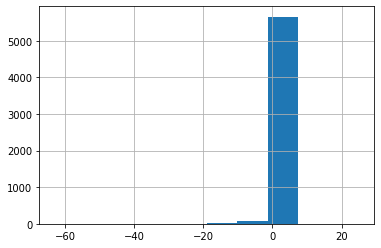

In [83]:
pd.Series(otm_itm_num_diff).hist()

In [53]:
vix = pd.read_csv("data/vix.csv",index_col=0)
vix.index = pd.to_datetime(vix.index)
spx_spot= spx_spot.join(vix["Close"],how="inner",rsuffix="_vix")
spx_spot["vix"] = spx_spot["Close"]
spx_target = spx_spot.loc[:,["ann_vol_30","vix"]]

spx_target.to_csv("data/spx_target.csv")